In [12]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('merged_prices.csv')

# Display basic info and first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                 Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                 --------------  ----- 
 0   day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss  30000 non-null  object
dtypes: object(1)
memory usage: 234.5+ KB


(None,
   day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
 0  -2,0,SQUID_INK,1998,26,,,,,2002,26,,,,,2000.0,0.0                                                                                                                                                   
 1  -2,100,SQUID_INK,1999,5,1998.0,26.0,,,2001,20,...                                                                                                                                                   
 2  -2,200,SQUID_INK,1997,31,,,,,2000,1,2001.0,30....                                                                                                                                                   
 3  -2,300,SQUID_INK,1997,27,,,,,2000,27,,,,,1998....                                                                                                                                        

In [13]:
# Split the single column into multiple columns by comma
df = df.iloc[:, 0].str.split(",", expand=True)

# Show the first few rows and inferred column count
df.columns = [
    "day", "timestamp", "product",
    "bid_price_1", "bid_volume_1",
    "bid_price_2", "bid_volume_2",
    "bid_price_3", "bid_volume_3",
    "ask_price_1", "ask_volume_1",
    "ask_price_2", "ask_volume_2",
    "ask_price_3", "ask_volume_3",
    "mid_price", "profit_and_loss"
]

df.head()


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,SQUID_INK,1998,26,,,,,2002,26,,,,,2000.0,0.0
1,-2,100,SQUID_INK,1999,5,1998.0,26.0,,,2001,20,,,,,2000.0,0.0
2,-2,200,SQUID_INK,1997,31,,,,,2000,1,2001.0,30.0,,,1998.5,0.0
3,-2,300,SQUID_INK,1997,27,,,,,2000,27,,,,,1998.5,0.0
4,-2,400,SQUID_INK,1996,20,,,,,2000,20,,,,,1998.0,0.0


In [14]:
# Convert relevant columns to numeric types
df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")
df["mid_price"] = pd.to_numeric(df["mid_price"], errors="coerce")
df["profit_and_loss"] = pd.to_numeric(df["profit_and_loss"], errors="coerce")

# Drop rows with missing mid_price or timestamp
df = df.dropna(subset=["timestamp", "mid_price"])

# Filter only SQUID_INK (if other products are present in the full file)
squid_df = df[df["product"] == "SQUID_INK"].copy()

# Show summary
squid_df[["timestamp", "mid_price", "profit_and_loss"]].describe()


,timestamp,mid_price,profit_and_loss
count,30000.000000,30000.000000,30000.0
mean,499950.000000,1971.111767,0.0
std,288679.944524,67.896204,0.0
min,0.000000,1810.500000,0.0
25%,249975.000000,1936.500000,0.0
50%,499950.000000,1965.000000,0.0
75%,749925.000000,1999.500000,0.0
max,999900.000000,2187.500000,0.0


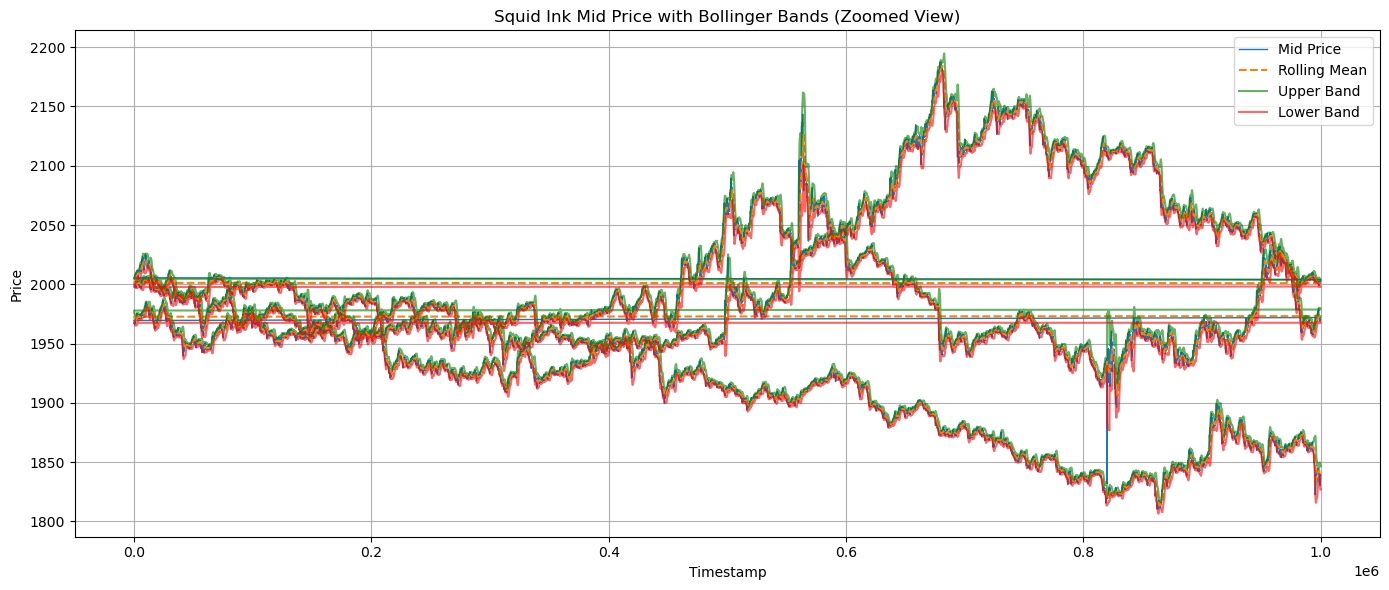

In [15]:
import matplotlib.pyplot as plt

# Step 1: Compute Bollinger Bands
window = 20
squid_df["rolling_mean"] = squid_df["mid_price"].rolling(window).mean()
squid_df["rolling_std"] = squid_df["mid_price"].rolling(window).std()
squid_df["upper_band"] = squid_df["rolling_mean"] + 2 * squid_df["rolling_std"]
squid_df["lower_band"] = squid_df["rolling_mean"] - 2 * squid_df["rolling_std"]

# Step 2: Plot mid price and Bollinger Bands
plt.figure(figsize=(14, 6))
plt.plot(squid_df["timestamp"], squid_df["mid_price"], label="Mid Price", linewidth=1)
plt.plot(squid_df["timestamp"], squid_df["rolling_mean"], label="Rolling Mean", linestyle="--")
plt.plot(squid_df["timestamp"], squid_df["upper_band"], label="Upper Band", color="green", alpha=0.6)
plt.plot(squid_df["timestamp"], squid_df["lower_band"], label="Lower Band", color="red", alpha=0.6)
plt.title("Squid Ink Mid Price with Bollinger Bands (Zoomed View)")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


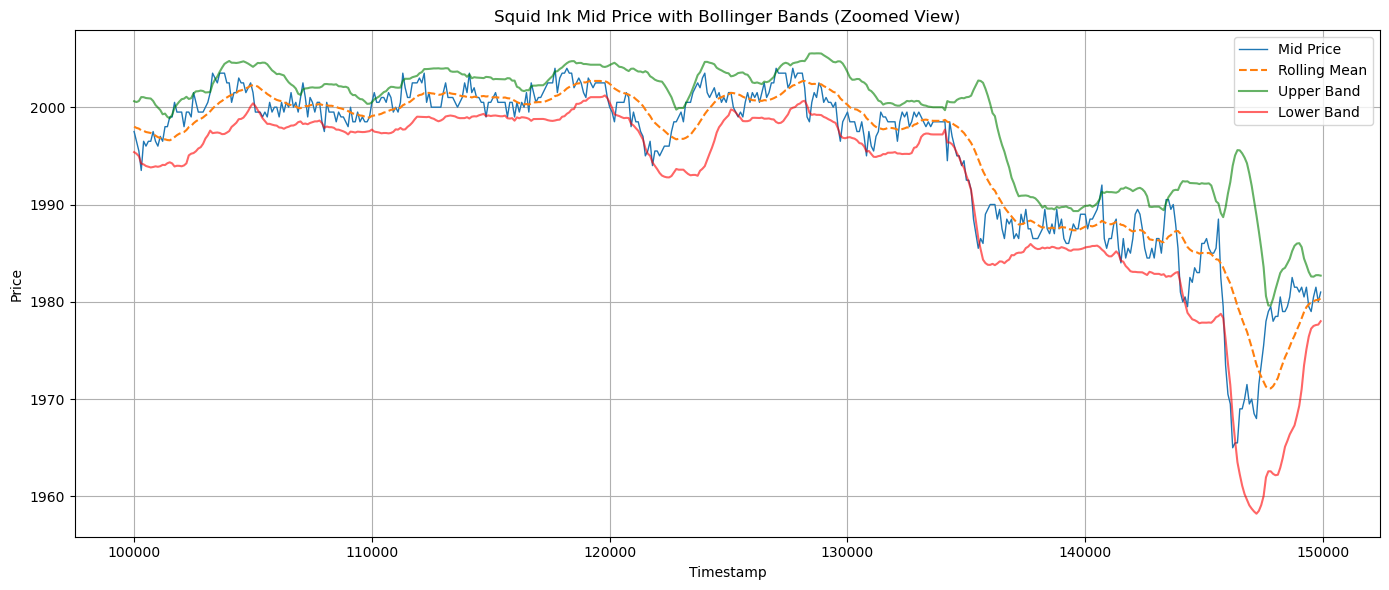

In [16]:
# Plot a limited segment of the data to make the Bollinger Bands visually meaningful
subset = squid_df.iloc[1000:1500]

plt.figure(figsize=(14, 6))
plt.plot(subset["timestamp"], subset["mid_price"], label="Mid Price", linewidth=1)
plt.plot(subset["timestamp"], subset["rolling_mean"], label="Rolling Mean", linestyle="--")
plt.plot(subset["timestamp"], subset["upper_band"], label="Upper Band", color="green", alpha=0.6)
plt.plot(subset["timestamp"], subset["lower_band"], label="Lower Band", color="red", alpha=0.6)
plt.title("Squid Ink Mid Price with Bollinger Bands (Zoomed View)")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [17]:
# Step 3: Simulate the strategy
position = 0
entry_price = 0
pnl = []

for i, row in squid_df.iterrows():
    price = row["mid_price"]
    upper = row["upper_band"]
    lower = row["lower_band"]
    mean = row["rolling_mean"]

    if pd.isna(upper) or pd.isna(lower):
        pnl.append(0)
        continue

    # Entry signals
    if position == 0:
        if price < lower:
            position = 1
            entry_price = price
        elif price > upper:
            position = -1
            entry_price = price
        pnl.append(0)
    
    # Exit signals
    elif position == 1:  # Long position
        if lower <= price <= upper:
            profit = price - entry_price
            pnl.append(profit)
            position = 0
        else:
            pnl.append(0)
    
    elif position == -1:  # Short position
        if lower <= price <= upper:
            profit = entry_price - price
            pnl.append(profit)
            position = 0
        else:
            pnl.append(0)

# Step 4: Analyze performance
squid_df["strategy_pnl"] = pnl
squid_df["cumulative_pnl"] = squid_df["strategy_pnl"].cumsum()

# Return summary stats
total_trades = (squid_df["strategy_pnl"] != 0).sum()
total_profit = squid_df["strategy_pnl"].sum()
avg_profit = squid_df["strategy_pnl"][squid_df["strategy_pnl"] != 0].mean()
win_rate = (squid_df["strategy_pnl"] > 0).sum() / total_trades

(total_trades, total_profit, avg_profit, win_rate)


(1559, 1017.5, 0.6526619627966646, 0.7767799871712636)

In [ ]:
import numpy as np

# Grid search ranges
window_range = range(3, 20, 1)
band_width_range = np.arange(.5, 2, .1)

# Store results
results = []

for window in window_range:
    # Compute rolling stats
    squid_df["rolling_mean"] = squid_df["mid_price"].rolling(window).mean()
    squid_df["rolling_std"] = squid_df["mid_price"].rolling(window).std()
    
    for band_width in band_width_range:
        # Compute bands
        squid_df["upper_band"] = squid_df["rolling_mean"] + band_width * squid_df["rolling_std"]
        squid_df["lower_band"] = squid_df["rolling_mean"] - band_width * squid_df["rolling_std"]

        # Simulate strategy
        position = 0
        entry_price = 0
        pnl = []

        for i, row in squid_df.iterrows():
            price = row["mid_price"]
            upper = row["upper_band"]
            lower = row["lower_band"]

            if pd.isna(upper) or pd.isna(lower):
                pnl.append(0)
                continue

            # Entry
            if position == 0:
                if price < lower:
                    position = 1
                    entry_price = price
                elif price > upper:
                    position = -1
                    entry_price = price
                pnl.append(0)

            # Exit
            elif position == 1 and lower <= price <= upper:
                pnl.append(price - entry_price)
                position = 0
            elif position == -1 and lower <= price <= upper:
                pnl.append(entry_price - price)
                position = 0
            else:
                pnl.append(0)

        squid_df["strategy_pnl"] = pnl
        total_profit = squid_df["strategy_pnl"].sum()
        trades = (squid_df["strategy_pnl"] != 0).sum()
        win_rate = (squid_df["strategy_pnl"] > 0).sum() / trades if trades > 0 else 0
        avg_profit = squid_df["strategy_pnl"][squid_df["strategy_pnl"] != 0].mean() if trades > 0 else 0

        results.append({
            "window": window,
            "band_width": band_width,
            "total_profit": total_profit,
            "trades": trades,
            "avg_profit": avg_profit,
            "win_rate": win_rate
        })

# Create DataFrame from results
results_df = pd.DataFrame(results)
results_df.to_csv("strategy_results.csv", index=False)

In [24]:
# load csv and display as df
results_df = pd.read_csv("strategy_results.csv")
results_df.head()
# Find the best parameters based on total profit
best_params = results_df.loc[results_df["total_profit"].idxmax()]
best_params

window             4.000000
band_width         0.900000
total_profit    3167.500000
trades          6032.000000
avg_profit         0.525116
win_rate           0.756300
Name: 95, dtype: float64

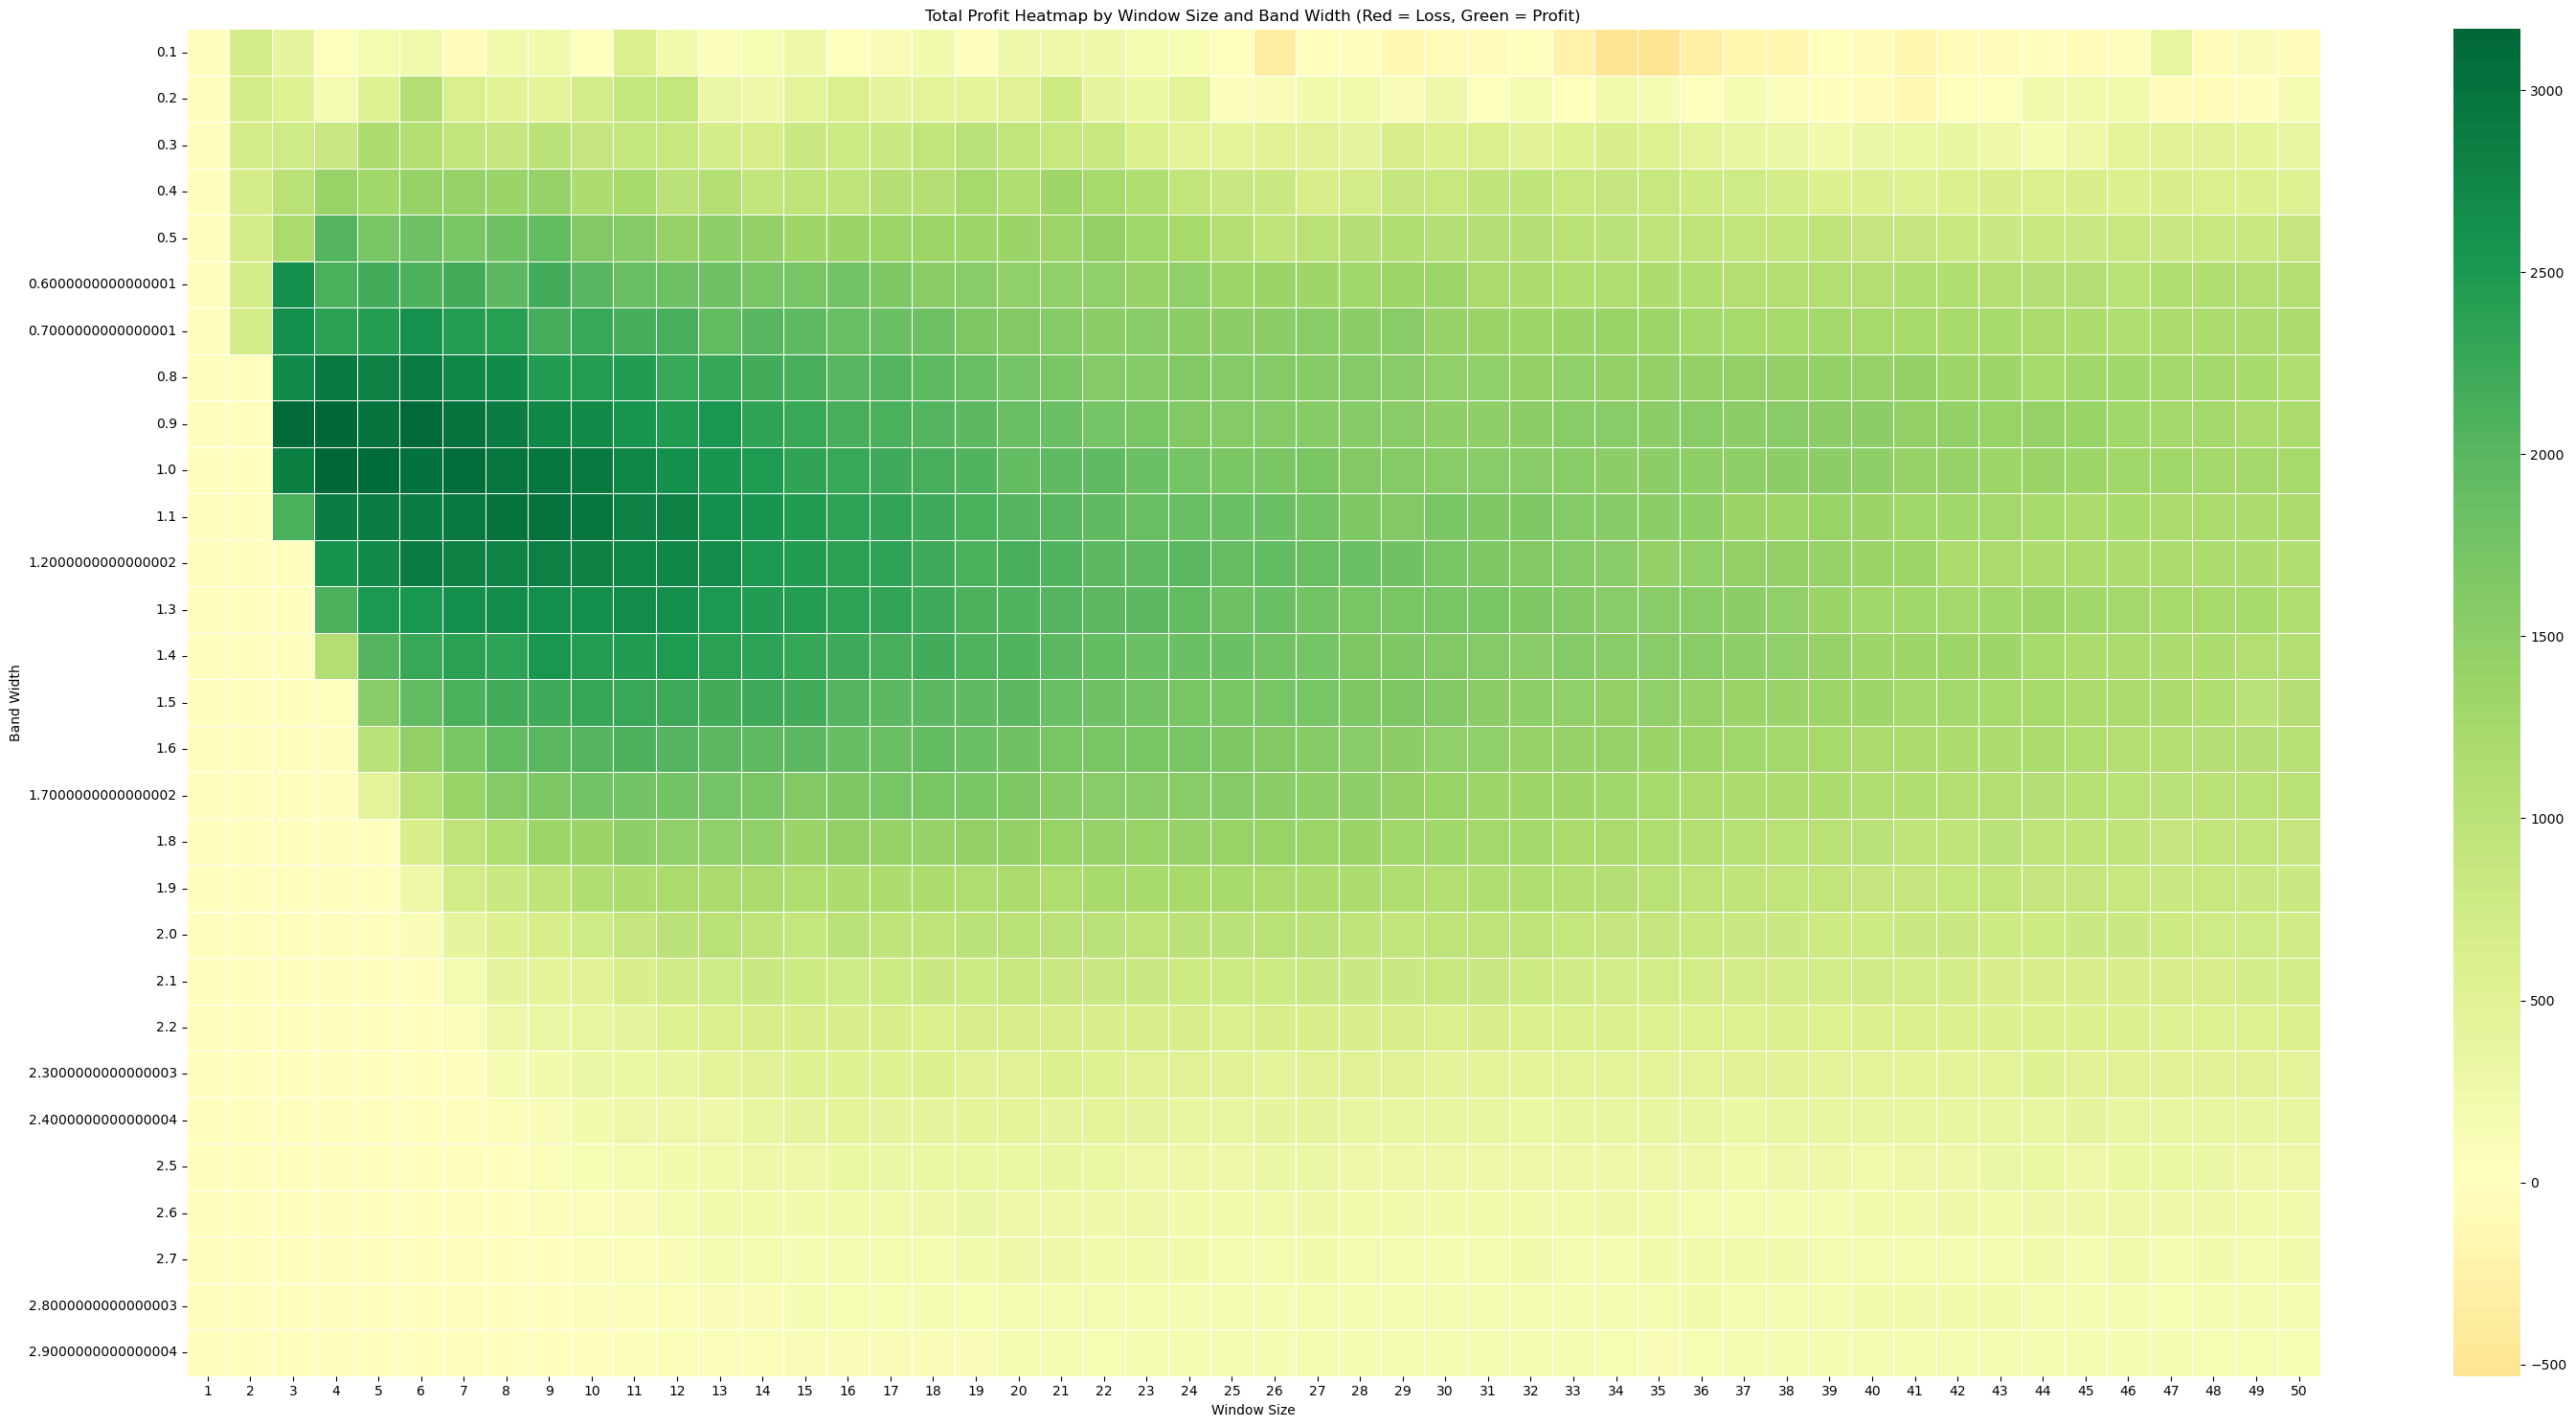

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table for heatmap (total profit as value)
heatmap_data = results_df.pivot(index="band_width", columns="window", values="total_profit")

plt.figure(figsize=(30, 15))
sns.heatmap(
    heatmap_data,
    annot=False,  # Disable text annotations
    cmap="RdYlGn",
    linewidths=0.5,
    center=0
)
plt.title("Total Profit Heatmap by Window Size and Band Width (Red = Loss, Green = Profit)")
plt.xlabel("Window Size")
plt.ylabel("Band Width")
plt.tight_layout()
plt.show()


In [ ]:
# narrowed search with worse fills
# First, make sure relevant columns are numeric
for col in ["bid_price_1", "ask_price_3"]:
    squid_df[col] = pd.to_numeric(squid_df[col], errors="coerce")

# Use best bid/ask prices for execution simulation
window_range = range(3, 20, 1)
band_width_range = np.arange(0.5, 2.0, 0.1)
results_bid_ask = []

for window in window_range:
    squid_df["rolling_mean"] = squid_df["mid_price"].rolling(window).mean()
    squid_df["rolling_std"] = squid_df["mid_price"].rolling(window).std()

    for band_width in band_width_range:
        squid_df["upper_band"] = squid_df["rolling_mean"] + band_width * squid_df["rolling_std"]
        squid_df["lower_band"] = squid_df["rolling_mean"] - band_width * squid_df["rolling_std"]

        position = 0
        entry_price = 0
        pnl = []

        for i, row in squid_df.iterrows():
            bid = row["bid_price_1"]
            ask = row["ask_price_3"]
            upper = row["upper_band"]
            lower = row["lower_band"]
            mid = row["mid_price"]

            if pd.isna(upper) or pd.isna(lower) or pd.isna(bid) or pd.isna(ask):
                pnl.append(0)
                continue

            # Entry at market (best ask if long, best bid if short)
            if position == 0:
                if mid < lower:
                    position = 1
                    entry_price = ask  # buy at ask
                    pnl.append(0)
                elif mid > upper:
                    position = -1
                    entry_price = bid  # sell at bid
                    pnl.append(0)
                else:
                    pnl.append(0)

            # Exit at market
            elif position == 1 and lower <= mid <= upper:
                pnl.append(bid - entry_price)  # sell at bid
                position = 0
            elif position == -1 and lower <= mid <= upper:
                pnl.append(entry_price - ask)  # buy at ask
                position = 0
            else:
                pnl.append(0)

        squid_df["strategy_pnl"] = pnl
        total_profit = squid_df["strategy_pnl"].sum()
        trades = (squid_df["strategy_pnl"] != 0).sum()
        win_rate = (squid_df["strategy_pnl"] > 0).sum() / trades if trades > 0 else 0
        avg_profit = squid_df["strategy_pnl"][squid_df["strategy_pnl"] != 0].mean() if trades > 0 else 0

        results_bid_ask.append({
            "window": window,
            "band_width": band_width,
            "total_profit": total_profit,
            "trades": trades,
            "avg_profit": avg_profit,
            "win_rate": win_rate
        })

# Create DataFrame from updated results and save
results_df_bid_ask = pd.DataFrame(results_bid_ask)
results_df_bid_ask.to_csv("strategy_results_bid_ask.csv", index=False)

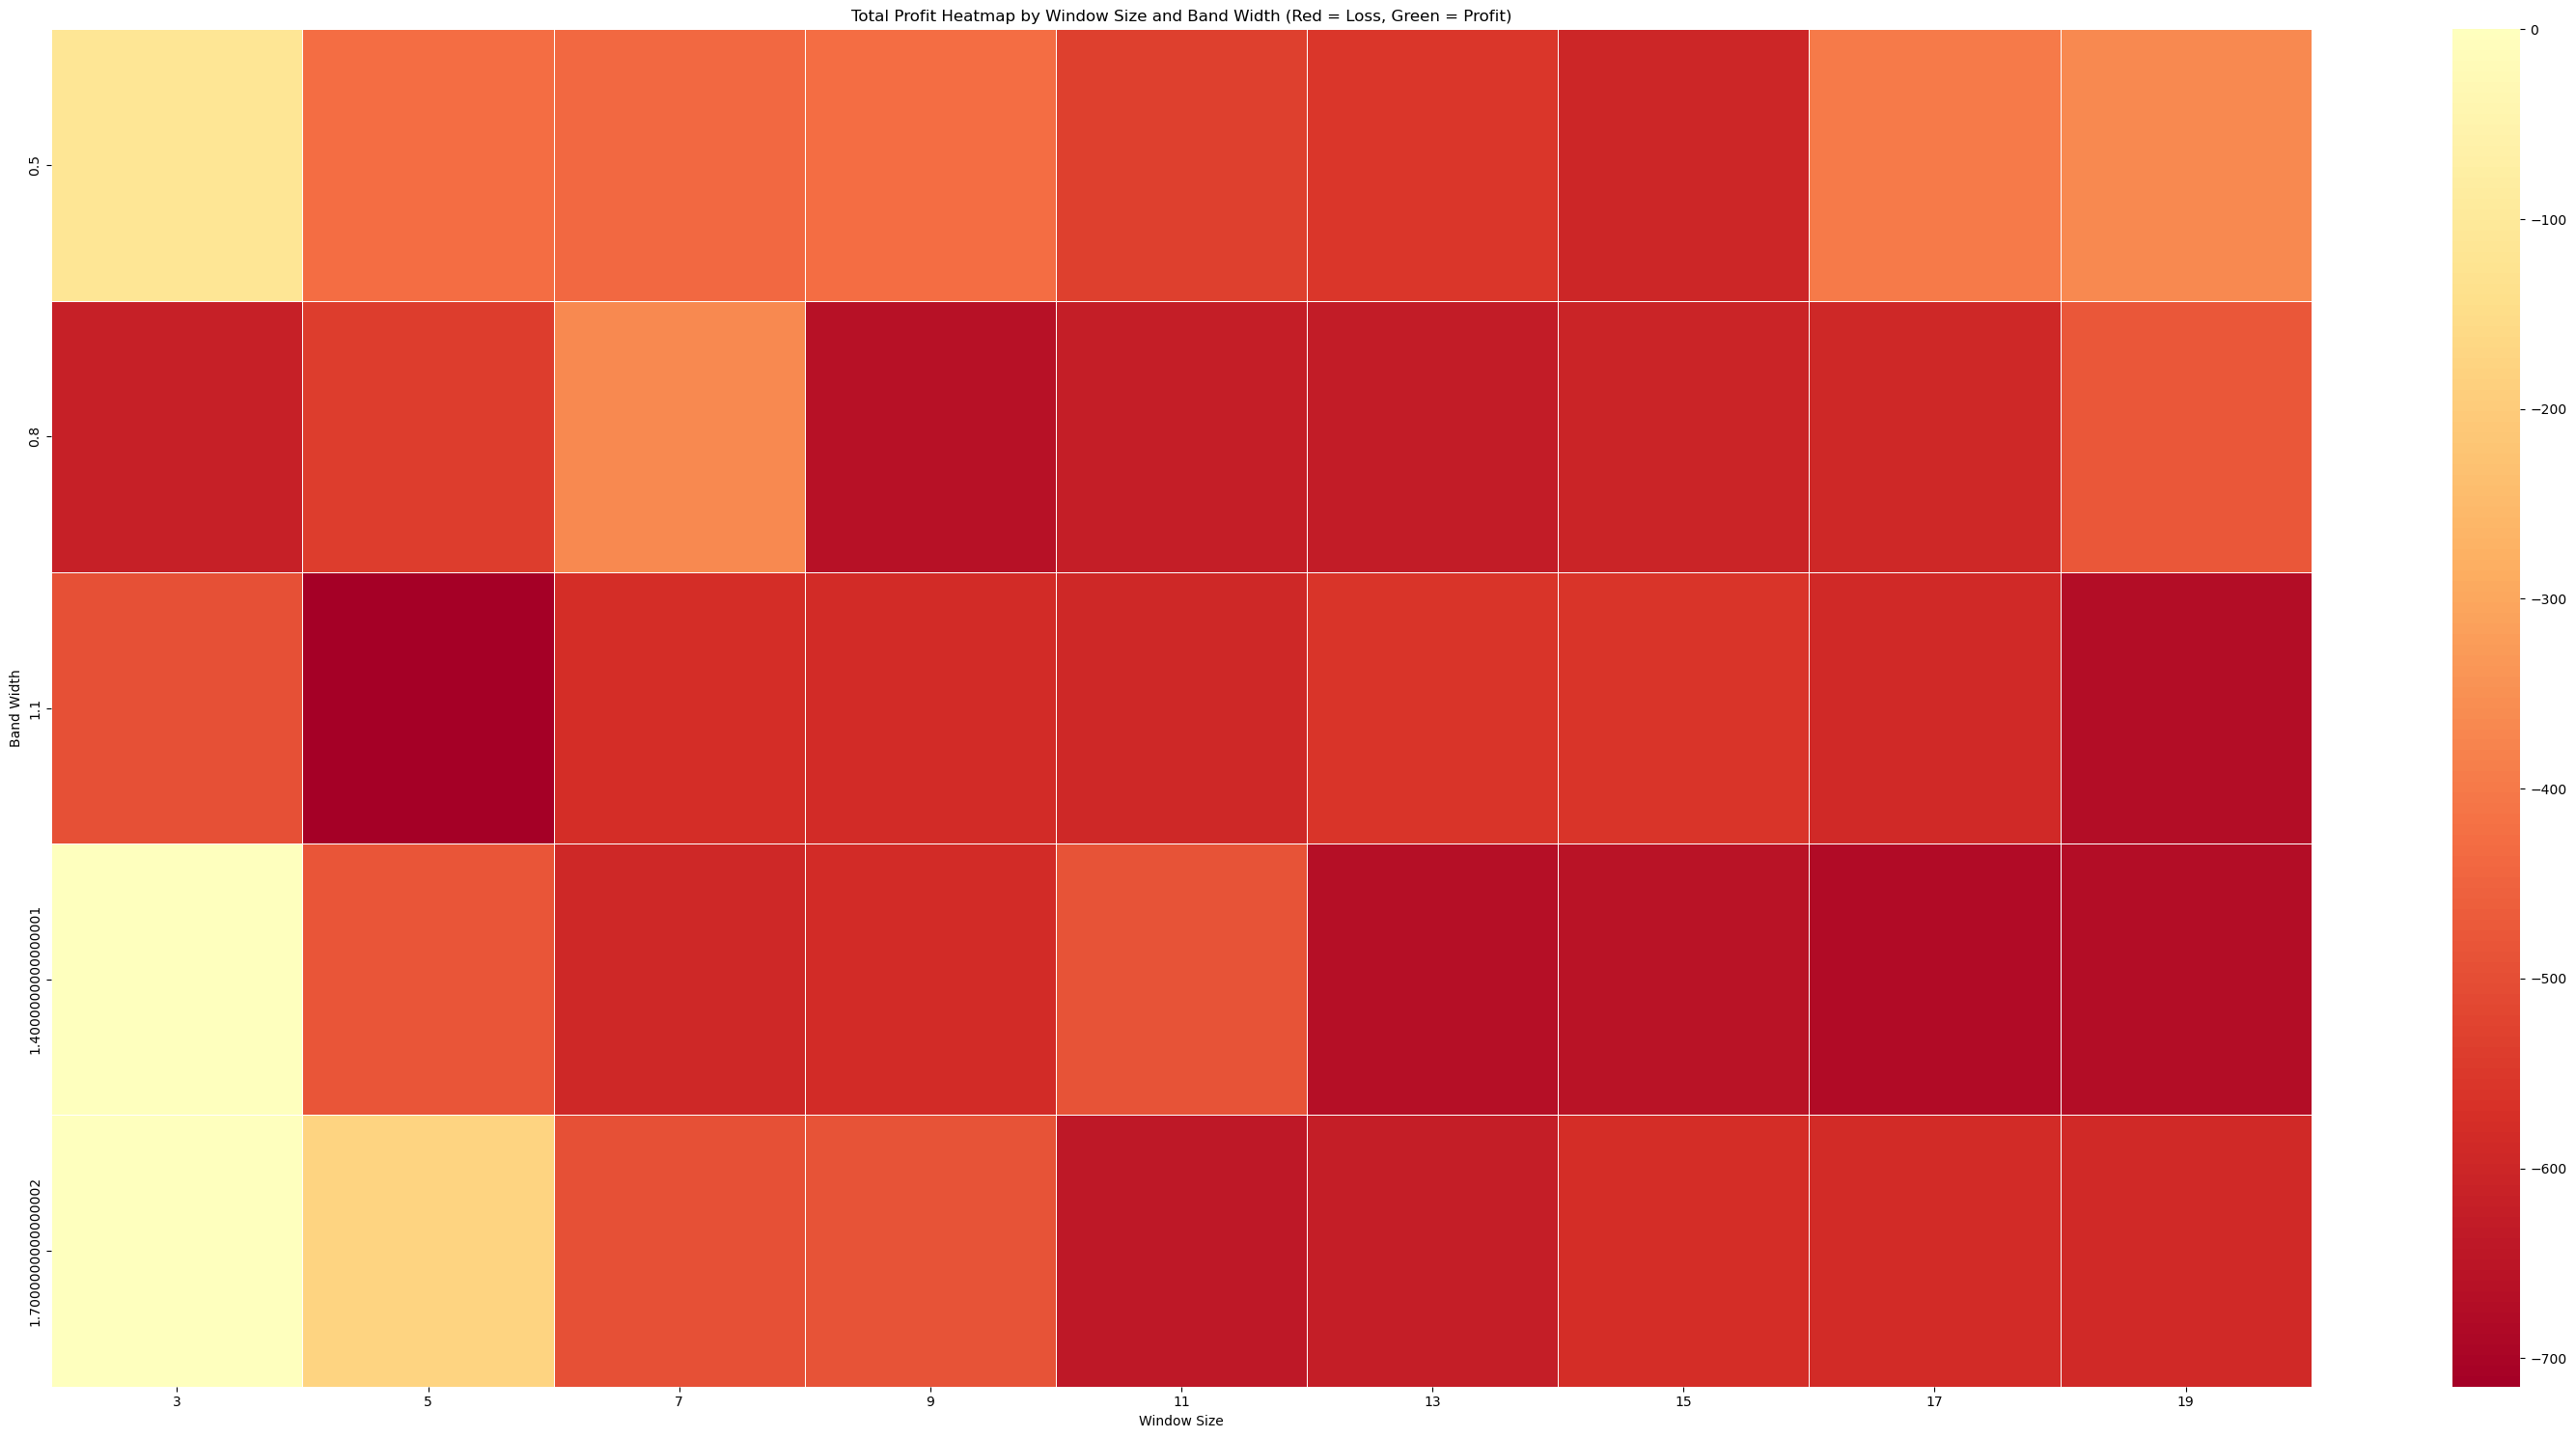

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table for heatmap (total profit as value)
heatmap_data = results_df_bid_ask.pivot(index="band_width", columns="window", values="total_profit")

plt.figure(figsize=(30, 15))
sns.heatmap(
    heatmap_data,
    annot=False,  # Disable text annotations
    cmap="RdYlGn",
    linewidths=0.5,
    center=0
)
plt.title("Total Profit Heatmap by Window Size and Band Width (Red = Loss, Green = Profit)")
plt.xlabel("Window Size")
plt.ylabel("Band Width")
plt.tight_layout()
plt.show()